# Color temperature as a function of the combined brightness of two light sources

The following notebook tries to illustrate the math behind this integration, explaining how to compute the resulting color temperature of a "virtual" combined light, given two light sources of varying brightness.

The notebook is interactive: you can change the variables defining the source lights and see the resulting plots!

## The source lights

We define the properties of our two lights here. The assumption is that there are two lights:
- warm_light
- cold_light

Each light source emits its own light at a fixed color temperature, and it is possible to separately control the brightness of each, from 0% (light is off) to 100% (light is on).

Since we are combining the output from these two lights, the combined light source is at max brightness (100%) when both the source lights are at 100%.\
Therefore the brightness is computed as the __average__ between the brightness of `warm` and `cold`.

The brightness is internally defined on a scale (0, 255) to conform to the internals of HA.

We also convert the temperature from Kelvin to _mired_ since it allows us to apply transformations in linear dimensions. See [Wikipedia](https://en.wikipedia.org/wiki/Mired) for a brief introduction to this unit.

In [7]:
WARM_TEMPERATURE_KELVIN=3000
COLD_TEMPERATURE_KELVIN=6000

# Do not modify the following, they are helper constants to help in the unit conversion/math computations
MAX_BRIGHTNESS = 255
WARM_TEMPERATURE_MIRED = 1000000 / WARM_TEMPERATURE_KELVIN
COLD_TEMPERATURE_MIRED = 1000000 / COLD_TEMPERATURE_KELVIN
HALF_POINT_MIRED = ( COLD_TEMPERATURE_MIRED + WARM_TEMPERATURE_MIRED) / 2
HALF_POINT_KELVIN = 1000000 / HALF_POINT_MIRED

In [8]:
from color_temperature_light_mixer.helper import BrightnessCalculator
import matplotlib.pyplot as plt
import numpy as np
from homeassistant.util.color import color_temperature_to_rgb

## Computing the combined color temperature

The resulting color temperature of the virtual light can be obtained by a weighted averaged sum of the two source color temperatures, using the brightness value of each light as the coefficient.

The following plot shows the range of possible color temperatures achievable using the inputs color temperature + brightnesses from the cold and warm light sources.

Text(6000, 0.99, 'cold color temperature')

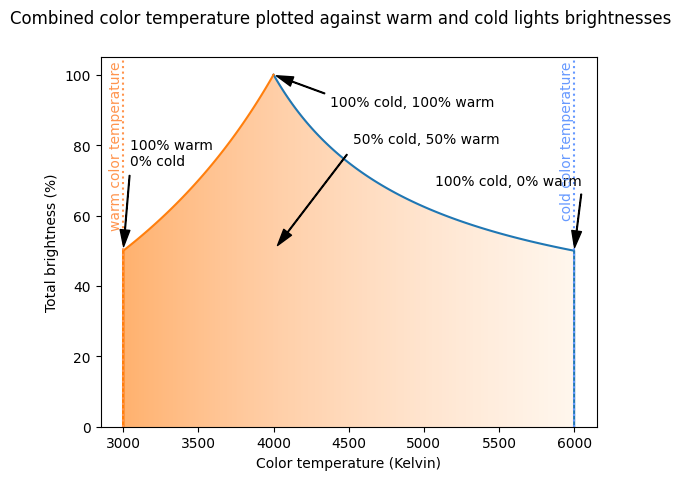

In [14]:
n_points = 100

# Define the temperature as two arrays, one for each half of the temperature spectrum
x_warm = np.linspace(COLD_TEMPERATURE_MIRED, HALF_POINT_MIRED, num=n_points, dtype=float)
x_cold = np.linspace(HALF_POINT_MIRED, WARM_TEMPERATURE_MIRED, num=n_points, dtype=float)

# Left upper bound of the brightness function
def max_warm_brightness(x):
    return MAX_BRIGHTNESS * (COLD_TEMPERATURE_MIRED - WARM_TEMPERATURE_MIRED) / (2 * (x - WARM_TEMPERATURE_MIRED))

# Right upper bound of the brightness function
def max_cold_brightness(x):
    return MAX_BRIGHTNESS * (COLD_TEMPERATURE_MIRED - WARM_TEMPERATURE_MIRED) / (2 * (COLD_TEMPERATURE_MIRED - x))

y_warm = max_warm_brightness(x_warm)
y_cold = max_cold_brightness(x_cold)

# Add two points to the start of the array to show the cold brightness vertical edge
x_warm = np.insert(x_warm, 0, [COLD_TEMPERATURE_MIRED,COLD_TEMPERATURE_MIRED])
y_warm = np.insert(y_warm, 0, [0,MAX_BRIGHTNESS/2])

# Add two points to the end of the array to show the warm brightness vertical edge
x_cold = np.append(x_cold, [WARM_TEMPERATURE_MIRED,WARM_TEMPERATURE_MIRED])
y_cold = np.append(y_cold, [0,MAX_BRIGHTNESS/2])

# Convert back to Kelvin
x_warm_kelvin = 1000000 / x_warm
x_cold_kelvin = 1000000 / x_cold

# Convert brightness to percentage
y_warm_pct = y_warm / MAX_BRIGHTNESS * 100
y_cold_pct = y_cold / MAX_BRIGHTNESS * 100


def fill_area():
    """Helper function to fill the area under the curve from color temperature to RGB color"""
    for i in range(n_points - 1):
        r, g, b = color_temperature_to_rgb(x_cold_kelvin[i])
        plt.fill_between([x_cold_kelvin[i], x_cold_kelvin[i+1]], [y_cold_pct[i], y_cold_pct[i+1]], color=(r/255,g/255,b/255))

    for i in range(n_points, 1, -1):
        r, g, b = color_temperature_to_rgb(x_warm_kelvin[i])
        plt.fill_between([x_warm_kelvin[i], x_warm_kelvin[i+1]], [y_warm_pct[i], y_warm_pct[i+1]], color=(r/255,g/255,b/255))

## Plot the result
fig, ax = plt.subplots()

ax.plot(x_warm_kelvin, y_warm_pct)
ax.plot(x_cold_kelvin, y_cold_pct)
fill_area()

ax.set_ylim(0)

ax.set_xlabel("Color temperature (Kelvin)")
ax.set_ylabel("Total brightness (%)")
plt.suptitle("Combined color temperature plotted against warm and cold lights brightnesses")

# Add annotations for some example points
ax.annotate('100% warm\n0% cold', 
            xy=(WARM_TEMPERATURE_KELVIN, 50), 
            xytext=(5, 70), ha="left", va="center",
            textcoords="offset points", 
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=7)
            )
ax.annotate('100% cold, 0% warm', 
            xy=(COLD_TEMPERATURE_KELVIN, 50), 
            xytext=(-100, 50), va="center",
            textcoords="offset points", 
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=7)
            )

ax.annotate('100% cold, 100% warm', 
            xy=(HALF_POINT_KELVIN, 100), 
            xytext=(100, -20), ha="center", va="center",
            textcoords="offset points", 
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=7)
            )

ax.annotate('50% cold, 50% warm', 
            xy=(HALF_POINT_KELVIN, 50), 
            xytext=(110, 80), ha="center", va="center",
            textcoords="offset points", 
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=7)
            )

# Vertical lines
ax.axvline(WARM_TEMPERATURE_KELVIN, color='#ff944d', ls=':')
ax.text(WARM_TEMPERATURE_KELVIN, 0.99, 'warm color temperature', color='#ff944d', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

ax.axvline(COLD_TEMPERATURE_KELVIN, color='#6699ff', ls=':')
ax.text(COLD_TEMPERATURE_KELVIN, 0.99, 'cold color temperature', color='#6699ff', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

The arrows points to some example combination of (`cold brightness`, `warm brightness`) brightness percentages and the resulting point defined as (_color temperature_, _combined brightness_).

__N.B.__: The resulting plot is not symmetric, since operating on the Kelvin temperature scale is not linear, since we are using a weighted sum of the source light temperatures, and transforming the results from the _mired_  linear space (where all the temperature averaging computations happen) back to the _Kelvin_ scale skews the results even more.

## Computing the brightness of each light from the combined brightness and color temperature

Whenever HA requests to set the _brightness_ AND the _color temperature_ of the virtual combined light (either because the user selected a slider via the UI, or an automation invokes the `light.turn_on` service), to achieve the end-result the passed-in values must be broken down into two values:

- brightness of the warm light
- brightness of the cold light

So that each light can be set accordingly to reach the target settings requested by HA.

By inverting the averaged sum function used before, it is possible to get back the two brightnesses required to achieve the target _brightness_ + _temperature_.

### Unknown settings

If HA or the user does not specify a value either for _brightness_ OR _color temperature_, the integration assumes that the goal is to keep the previously set value for the missing parameter.

For example:

|Current brightness (%)|Current temperature (K)|Requested brightness (%)|Requested temperature (K)|Computed values (%,K)|
|---|---|---|---|---|
|10|3000|45|4500|45,4500|
|10|3000||4500|__10__,4500|
|10|3000|45||45,__3000__|
|10|3000|||__10__,__3000__|

## Handling unreachable combinations of brightness + color temperature

HA assumes that a color-changing light can reach any combination of (_brightness_, _color temperature_), whereas as shown in the first plot above it is not always possible to do so.\
For instance the following combination is not achievable by the two combined light sources:
- color temperature: 5500 K
- brightness: 85%

It is shown as a point in the plot below, and it is visibly outside the possible ranges of temperature and brightness combinations.

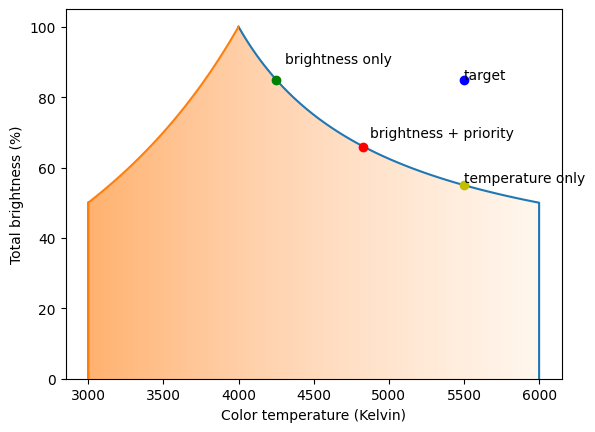

In [20]:
from color_temperature_light_mixer.helper import BrightnessTemperaturePriority

# Change the following parameters to move the target point
TARGET_TEMPERATURE_KELVIN = 5500
TARGET_BRIGHTNESS = 85
#####################

target_temperature_mired = 1000000 / TARGET_TEMPERATURE_KELVIN

fig, ax = plt.subplots()

ax.plot(x_warm_kelvin, y_warm_pct)
ax.plot(x_cold_kelvin, y_cold_pct)

# Target point
ax.plot(TARGET_TEMPERATURE_KELVIN, TARGET_BRIGHTNESS, 'bo')
ax.annotate("target", (TARGET_TEMPERATURE_KELVIN, TARGET_BRIGHTNESS))

# Temperature priority
vertical_intercept_y = max_warm_brightness(target_temperature_mired) / MAX_BRIGHTNESS * 100
ax.plot(TARGET_TEMPERATURE_KELVIN, vertical_intercept_y, 'yo')
ax.annotate("temperature only", 
            (TARGET_TEMPERATURE_KELVIN, vertical_intercept_y),
            va="bottom",
            )

def horizontal_intercept_mired(y):
    return (MAX_BRIGHTNESS * COLD_TEMPERATURE_MIRED + (2 * y * WARM_TEMPERATURE_MIRED) - MAX_BRIGHTNESS * WARM_TEMPERATURE_MIRED) / (2 * y)

# Brightness priority
horizontal_intercept_x = 1000000 / horizontal_intercept_mired(255 * TARGET_BRIGHTNESS / 100)
ax.plot(horizontal_intercept_x, TARGET_BRIGHTNESS, 'go')
ax.annotate("brightness only", (horizontal_intercept_x, TARGET_BRIGHTNESS),
            xytext=(45, 10), 
            ha="center", 
            va="bottom",
            textcoords="offset points"
)

# Mixed priority
brightness_calc = BrightnessCalculator(
    warm_temperature_kelvin=WARM_TEMPERATURE_KELVIN,
    cold_temperature_kelvin=COLD_TEMPERATURE_KELVIN,
    target_brightness=TARGET_BRIGHTNESS,
    target_temperature_kelvin=TARGET_TEMPERATURE_KELVIN,
    priority=BrightnessTemperaturePriority.MIXED
)
# Flip the temperature on the first half of the range to run the search algorithm from the left to the right
mirrored_temperature_mired = (
    2 * HALF_POINT_MIRED - target_temperature_mired
)
# Run the search algorithm to find a new closer point to hyperbola
mixed_priority_mired, mixed_priority_brightness = brightness_calc._find_closest_achievable_target(
    int(mirrored_temperature_mired), 
    int(WARM_TEMPERATURE_MIRED), 
    int(COLD_TEMPERATURE_MIRED))
mixed_priority_x = 1000000/mixed_priority_mired
mixed_priority_y = mixed_priority_brightness / MAX_BRIGHTNESS * 100

ax.plot(mixed_priority_x, mixed_priority_y, 'ro')
ax.annotate("brightness + priority", (mixed_priority_x, mixed_priority_y),
            xytext=(5, 5), 
            ha="left", 
            va="bottom",
            textcoords="offset points"
)

ax.set_ylim(0)

ax.set_xlabel("Color temperature (Kelvin)")
ax.set_ylabel("Total brightness (%)")
fill_area()

### Finding an achievable combination

If the integration detects an unreachable condition, it chooses another combination of (_brightness_, _color temperature_) such that it is achievable by the source lights, trying at the same time to meet the desired outcome described in the `light.turn_on` service call as close as possible.

It uses the following algorithm, depending on the type of change required in the `light.turn_on` service call it is handling:

- __brightness__ only -> give priority to the requested __brightness__ (move the target point horizontally until it meets the reachable area)
- __temperature__ only -> give priority to the requested __temperature__ (move the target point vertically until it meets the reachable area)
- __brightness__ and __temperature__ -> give priority to a combination of __temperature__ + __brightness__ (find the closest point to the target point such that it is inside the reachable area)

Given a new and valid combination of (_brightness_, _color temperature_), the integration then computes the brightness of each light source as before.

## Alternative function definition
Here the brightness values is a single np.array() computed with multiple piece-wise functions. 

This part of the notebook is not used.

(0.0, 266.8575)

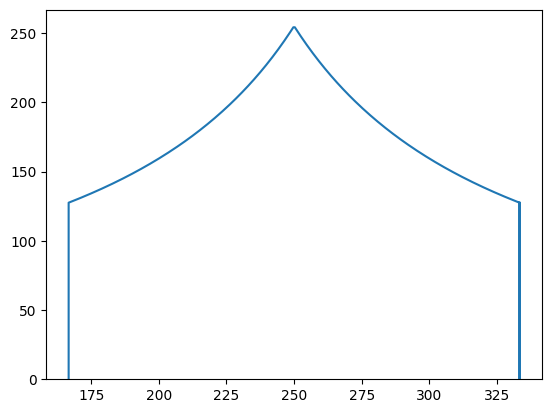

In [5]:
# Same as before, but defined as a single numpy array using np.piecewise().
n_points=300
x_mired = np.linspace(COLD_TEMPERATURE_MIRED, WARM_TEMPERATURE_MIRED, num=n_points, dtype=float)

first_half_condition = x_mired <= HALF_POINT_MIRED
second_half_condition = x_mired > HALF_POINT_MIRED

def max_warm_brightness(x):
    return MAX_BRIGHTNESS * (COLD_TEMPERATURE_MIRED - WARM_TEMPERATURE_MIRED) / (2 * (x - WARM_TEMPERATURE_MIRED))

def max_cold_brightness(x):
    return MAX_BRIGHTNESS * (COLD_TEMPERATURE_MIRED - WARM_TEMPERATURE_MIRED) / (2 * (COLD_TEMPERATURE_MIRED - x))

y_brightness = np.piecewise(x_mired, [first_half_condition, second_half_condition], [max_warm_brightness, max_cold_brightness])

# Add two points to the start of the array to show the cold brightness vertical edge
x_mired = np.insert(x_mired, 0, [COLD_TEMPERATURE_MIRED, COLD_TEMPERATURE_MIRED])
y_brightness = np.insert(y_brightness, 0, [0, MAX_BRIGHTNESS/2])

# Add two points to the end of the array to show the warm brightness vertical edge
x_mired = np.append(x_mired, [WARM_TEMPERATURE_MIRED,WARM_TEMPERATURE_MIRED])
y_brightness = np.append(y_brightness, [0,MAX_BRIGHTNESS/2])

fig, ax = plt.subplots()
ax.plot(x_mired, y_brightness)
plt.ylim(0)